# Análisis de Rendimiento: Cálculo de $\pi$ y Fibonacci
Este notebook presenta los resultados y el análisis de los programas desarrollados para el laboratorio.

[Video de referencia](https://www.youtube.com/watch?v=-TK9jYoqOro)

## Sección 1: Análisis de $\pi$

### Evaluación de $T_s$ (Tiempo Serial)
El tiempo de ejecución de la versión serial (`./pi_s`) con $n = 2,000,000,000$ es:
**$T_s = 5.338126$ segundos**

### Evaluación de $T_p$ (Tiempo Paralelo)
Los tiempos de ejecución de la versión paralela (`./pi_p`) variando el número de hilos ($N$) son:

*   $N=1$: $5.276137$ s
*   $N=2$: $3.447710$ s
*   $N=4$: $2.865640$ s
*   $N=8$: $2.416540$ s
*   $N=16$: $2.506032$ s

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos recolectados
ts = 5.338126
data = {
    'N_Hilos': [1, 2, 4, 8, 16],
    'Tp_segundos': [5.276137, 3.447710, 2.865640, 2.416540, 2.506032]
}

df = pd.DataFrame(data)

# Calcular Speedup y Eficiencia
df['Speedup'] = ts / df['Tp_segundos']
df['Eficiencia'] = df['Speedup'] / df['N_Hilos']

# Mostrar Tabla de Resultados
display(df)

,N_Hilos,Tp_segundos,Speedup,Eficiencia
0,1,5.276137,1.011749,1.011749
1,2,3.447710,1.548311,0.774155
2,4,2.865640,1.862804,0.465701
3,8,2.416540,2.208996,0.276124
4,16,2.506032,2.130111,0.133132


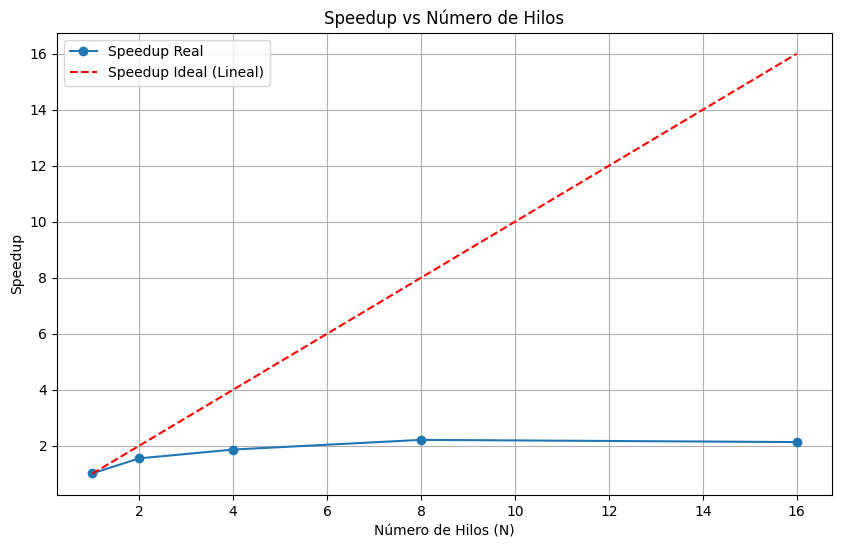

In [3]:
# Gráfico de Speedup
plt.figure(figsize=(10, 6))
plt.plot(df['N_Hilos'], df['Speedup'], marker='o', label='Speedup Real')
plt.plot(df['N_Hilos'], df['N_Hilos'], 'r--', label='Speedup Ideal (Lineal)')
plt.xlabel('Número de Hilos (N)')
plt.ylabel('Speedup')
plt.title('Speedup vs Número de Hilos')
plt.legend()
plt.grid(True)
plt.show()

### Análisis de Resultados (Parte 1)

1.  **Comparación $T_p(1)$ vs $T_s$:**
    *   $T_s \approx 5.34$ s
    *   $T_p(1) \approx 5.28$ s
    *   **Análisis de Discrepancia (Overhead):** Teóricamente, se esperaría que $T_p(1)$ fuera ligeramente mayor que $T_s$ debido al *overhead* (sobrecosto) introducido por la creación del hilo (`pthread_create`), la gestión de la estructura de datos y la sincronización (`pthread_join`). Sin embargo, en esta ejecución observamos que $T_p(1)$ es ligeramente menor. Esto puede atribuirse a fluctuaciones normales en la carga del sistema operativo o a que el planificador de hilos asignó el hilo único a un núcleo menos ocupado en ese momento preciso. La diferencia es mínima, lo que confirma que para una carga de trabajo grande (2 mil millones de iteraciones), el overhead de Pthreads es despreciable.

2.  **Speedup Máximo:**
    *   El Speedup máximo se alcanzó con **8 hilos**, con un valor aproximado de **2.21**.
    *   **Comparación con Núcleos Físicos:** El speedup no escala linealmente. Con 4 hilos tenemos un speedup de ~1.86 y con 8 hilos sube a ~2.21. El hecho de que el speedup se sature y no llegue a valores cercanos a 4 u 8 sugiere que el sistema podría tener un número limitado de núcleos físicos (posiblemente 2 o 4) o que estamos ejecutando en un entorno virtualizado (WSL) donde los recursos de CPU están compartidos o limitados. La caída de rendimiento al pasar a 16 hilos confirma que hemos excedido la capacidad de paralelismo hardware útil, entrando en una zona de contención y overhead de cambio de contexto.

3.  **Tendencia de la Eficiencia:**
    *   La eficiencia disminuye drásticamente a medida que aumenta $N$.
    *   Con $N=2$, la eficiencia es $\approx 0.77$, pero con $N=8$ cae a $\approx 0.27$.
    *   **Causas:** La principal causa es que el speedup no crece al mismo ritmo que el número de hilos. Esto se debe a la **Ley de Amdahl** (la parte serial del código limita la mejora máxima) y a limitaciones de hardware como el ancho de banda de memoria compartido. Al aumentar los hilos más allá de los núcleos físicos, los hilos compiten por tiempo de CPU, reduciendo la eficiencia global de cada hilo individual.

## Sección 2: Análisis de Fibonacci

### Resultados de Ejecución
Salida del programa `./fibonacci 15`:
```
Fibonacci sequence of 15 numbers:
0 1 1 2 3 5 8 13 21 34 55 89 144 233 377
```

### Análisis del Diseño (Parte 2)

1.  **Mecanismo de Transferencia de Datos:**
    *   Se utilizó una estructura (`struct ThreadData`) para pasar los argumentos al hilo trabajador.
    *   Específicamente, el hilo `main` asigna memoria dinámica (`malloc`) para el arreglo compartido antes de crear el hilo.
    *   Se pasa el puntero a este arreglo (y el entero $N$) al hilo trabajador a través del argumento `void* arg` de la función del hilo. Esto permite que ambos hilos (main y trabajador) compartan el mismo espacio de memoria para los resultados.

2.  **Rol de `pthread_join`:**
    *   `pthread_join` es crucial para la sincronización. Actúa como una barrera que bloquea al hilo `main` hasta que el hilo trabajador termina su ejecución.
    *   Sin `pthread_join`, el hilo `main` podría intentar imprimir el contenido del arreglo antes de que el hilo trabajador haya terminado de calcularlo (condición de carrera), lo que resultaría en datos incorrectos o basura (ceros o valores no inicializados).
    *   Garantiza que la secuencia de Fibonacci esté completamente generada y almacenada en memoria antes de proceder a la fase de impresión.